In [3]:
using Pkg

In [4]:
Pkg.activate(".")

  Activating project at `~/phome/julia/AutoMLPipeline.jl/AutoAI`


In [5]:
using AutoAI
using Statistics
using Random
using DataFrames: DataFrame
using Plots
using CSV

In [6]:
using Distributed
nprocs()==1 && addprocs(exeflags=["--project=$(Base.active_project())"])
@everywhere using AutoAI

      From worker 3:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 3:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/AutoAI/.CondaPkg/lock"
      From worker 4:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 4:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/AutoAI/.CondaPkg/lock"
      From worker 7:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 7:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/AutoAI/.CondaPkg/lock"
      From worker 6:	┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
      From worker 6:	└   lock_file = "/Users/ppalmes/phome/julia/AutoMLPipeline.jl/AutoAI/.CondaPkg/lock"
      From worker 9:	┌ Info: CondaPkg: Waiting for lock to be fr

In [7]:
function ad1(df)
  dfres = DataFrame()
  for learner in keys(AutoAI.CaretAnomalyDetectors.caretadlearner_dict)
    model = CaretAnomalyDetector(learner)
    res = fit_transform!(model, df)
    mname = string(learner)
    dfres = hcat(dfres, DataFrame(mname => res; makeunique=true))
  end
  return dfres
end

ad1 (generic function with 1 method)

In [8]:
function ad2(df)
  clf1 = SKAnomalyDetector("IsolationForest")
  clf2 = SKAnomalyDetector("EllipticEnvelope")
  clf3 = SKAnomalyDetector("OneClassSVM")
  clf4 = SKAnomalyDetector("LocalOutlierFactor")
  res1 = fit_transform!(clf1, df)
  res2 = fit_transform!(clf2, df)
  res3 = fit_transform!(clf3, df)
  res4 = fit_transform!(clf4, df)
  return DataFrame(iso=res1, eli=res2, osvm=res3, lcl=res4)
end


ad2 (generic function with 1 method)

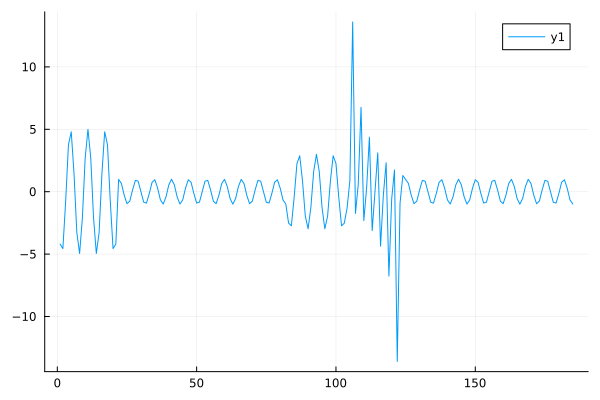

In [9]:
df1 = vcat(5*cos.(-10:10),sin.(-30:30),3*cos.(-10:10),2*tan.(-10:10),sin.(-30:30)) |> x -> DataFrame([x], :auto);
plot(df1.x1)

### Anomaly Detection by AutoML

In [10]:
function combine(df)
    a=hcat(ad1(df),ad2(df))
    hcat(a,mean.(eachrow(a)))
end

combine (generic function with 1 method)

In [11]:
ydf1=combine(df1)

PythonCall.Core.Py


Row,sod,iforest,histogram,mcd,sos,abod,svm,cluster,pca,knn,lof,cof,iso,eli,osvm,lcl,x1
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0.25
2,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0.25
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,0.375
5,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,1,0.5
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0.1875
7,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0.1875
8,0,1,0,1,0,1,1,0,1,0,0,0,1,1,1,0,0.5
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.125


#### Find anomalies based on fractions of votes among detectors

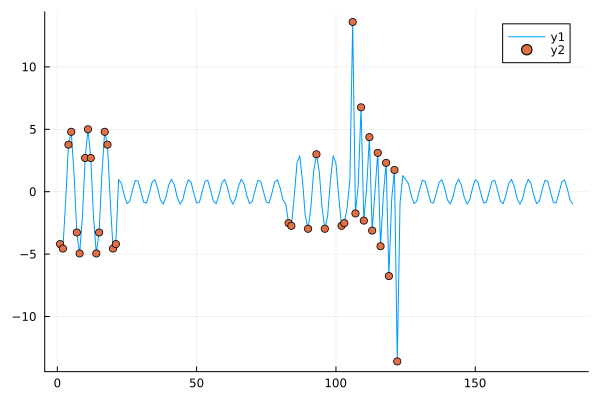

In [12]:
ndx=findall(x->x>=0.5,ydf1.iso)
Plots.plot(df1.x1)
scatter!(ndx,df1.x1[ndx])

### Time Series Prediction by AutoML

In [13]:
Random.seed!(10)
df2 = sin.(-30:30) |> x -> DataFrame([x], :auto)
bmodel = CaretTSPredictor("auto", Dict(:verbose => true,:forecast_horizon=>10))
bestres = fit_transform!(bmodel, df2)

                                         Description                    Value
0                                         session_id                      123
1                                             Target                        0
2                                           Approach               Univariate
3                                Exogenous Variables              Not Present
4                                Original data shape                  (61, 1)
5                             Transformed data shape                  (61, 1)
6                        Transformed train set shape                  (60, 1)
7                         Transformed test set shape                   (1, 1)
8                           Rows with missing values                     0.0%
9                                     Fold Generator  ExpandingWindowSplitter
10                                       Fold Number                        3
11                       Enforce Prediction Interval            

[ Info: evaluating the best model: AutoARIMA(random_state=123, sp=6, suppress_warnings=True)


10-element Vector{Float64}:
 -0.4037
  0.5523
  1.0008
  0.529
 -0.4296
 -0.9936
 -0.6433
  0.2999
  0.9683
  0.7459

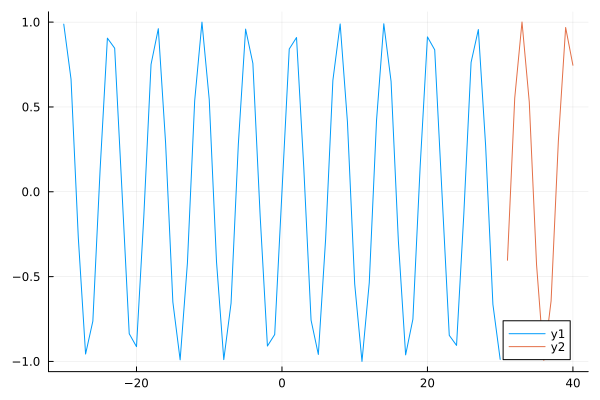

In [15]:
x=-30:30
y=sin.(x)
ll=length(y)
plot(x,y)
plot!(31:31+length(bestres)-1,bestres)

### AutoClassification and AutoRegression

#### Get the data

In [16]:
df3 = CSV.File("./test/iris.csv") |> DataFrame
first(df3,5)

Row,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


### AutoClassification

In [23]:
X = df3[:, 1:end-1]
Y = df3[:, end] |> collect
autoclass = AutoClassification()
Yhat = fit_transform!(autoclass, X, Y);

      From worker 3:	fold: 1, 0.9803921568627452
      From worker 2:	fold: 1, 0.9391534391534391
      From worker 3:	fold: 2, 0.8958333333333334
      From worker 4:	fold: 1, 0.918954248366013
      From worker 3:	fold: 3, 0.9649122807017544
      From worker 3:	errors: 0
      From worker 2:	fold: 2, 0.9583333333333334
      From worker 4:	fold: 2, 0.8183694530443756
      From worker 2:	fold: 3, 0.9814814814814815
      From worker 2:	errors: 0
      From worker 4:	fold: 3, 0.9583333333333334
      From worker 4:	errors: 0
modelsperf = 3×4 DataFrame
 Row │ Description            mean      sd         Pipeline
     │ String                 Float64   Float64    Pipeline
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │ (rb |> pca) |> rfc     0.959656  0.021195   Pipeline("linearpipeline_HgB", D…
   2 │ (rb |> pca) |> rbfsvc  0.947046  0.0450217  Pipeline("linearpipeline_sBM", D…
   3 │ (rb |> pca) |> gbc     0.898552  0.0721779  Pipeline("lin

#### Description of the best pipeline

In [18]:
autoclass.model[:bestpipeline].model[:description]

"(norm |> pca) + (norm |> pca) |> rbfsvc"

#### Get the pipeline functional expression

In [19]:
autoclass.model[:bestpipeline]

Pipeline("linearpipeline_Q67", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :description => "(norm |> pca) + (norm |> pca) |> rbfsvc", :name => "linearpipeline_Q67", :machines => Machine[Pipeline("linearpipeline_8J2_mbh", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_8J2_mbh", :machines => Machine[ComboPipeline("combopipeline_C1b_Zf1", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "combopipeline_C1b_Zf1", :machines => Machine[Pipeline("linearpipeline_V9M_31p", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_V9M_31p", :machines => Machine[CatFeatureSelector("catf_Qv1_3pr", Dict{Symbol, Any}(:name => "catf_Qv1_3pr", :nominal_columns => Int64[])), OneHotEncoder("ohe_dUw_HSD", Dict{Symbol, Any}(:nominal_column_values_map => Dict{Int64, Any}(), :name => "ohe_dUw_HSD", :nominal_columns => Int64[]))])), NumFeatureSelector("numf_QNa_UvZ", Dict{Symbol, Any}(:name => "numf_QNa_UvZ", :numcols => [1, 

### AutoRegression

In [20]:
X = df3[:, [1, 2, 3, 5]]
Y = df3[:, 4] |> collect
autoreg = AutoRegression()
Yhat = fit_transform!(autoreg, X, Y);

      From worker 3:	fold: 1, 0.03145684348806703
      From worker 4:	fold: 1, 0.03530272770137089
      From worker 3:	fold: 2, 0.03758426615556967
      From worker 2:	fold: 1, 0.26914716555555535
      From worker 4:	fold: 2, 0.03169838595767082
      From worker 3:	fold: 3, 0.026122497266732377
      From worker 3:	errors: 0
      From worker 4:	fold: 3, 0.05894681637139627
      From worker 4:	errors: 0
      From worker 2:	fold: 2, 0.03913941464489816
      From worker 2:	fold: 3, 0.026790613622222206
      From worker 2:	errors: 0
modelsperf = 3×4 DataFrame
 Row │ Description         mean       sd          Pipeline
     │ String              Float64    Float64     Pipeline
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ (rb |> pca) |> svr  0.0317212  0.00573546  Pipeline("linearpipeline_yHW", D…
   2 │ (rb |> pca) |> gbr  0.0419826  0.0148015   Pipeline("linearpipeline_Wq7", D…
   3 │ (rb |> pca) |> rfr  0.111692   0.1365      Pipelin

#### Description of the best Regression Pipeline

In [21]:
autoreg.model[:bestpipeline].model[:description]

"(norm |> pca) |> svr"

#### Best Pipeline Function description

In [22]:
autoreg.model[:bestpipeline]

Pipeline("linearpipeline_iAP", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :description => "(norm |> pca) |> svr", :name => "linearpipeline_iAP", :machines => Machine[Pipeline("linearpipeline_DBk_Zu0", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_DBk_Zu0", :machines => Machine[ComboPipeline("combopipeline_GW5_bOt", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "combopipeline_GW5_bOt", :machines => Machine[Pipeline("linearpipeline_ij1_M5g", Dict{Symbol, Any}(:machine_args => Dict{Symbol, Any}(), :name => "linearpipeline_ij1_M5g", :machines => Machine[CatFeatureSelector("catf_f61_htF", Dict{Symbol, Any}(:name => "catf_f61_htF", :nominal_columns => [4])), OneHotEncoder("ohe_iCH_E9X", Dict{Symbol, Any}(:nominal_column_values_map => Dict{Int64, Any}(1 => String15["setosa", "versicolor", "virginica"]), :name => "ohe_iCH_E9X", :nominal_columns => [1]))])), NumFeatureSelector("numf_hNh_45V", Dict{Symbol, Any}(:name => "numf_hNh